In [1]:
## from ctypes import *
#ctypes.cdll.LoadLibrary('')
#lib1 = CDLL("deps/sparse_rrt/deps/trajopt/build/lib/libsco.so")
#lib2 = CDLL("deps/sparse_rrt/deps/trajopt/build/lib/libutils.so")

import sys
sys.path.append('deps/sparse_rrt')
sys.path.append('.')

from sparse_rrt.planners import SST
#from env.cartpole_obs import CartPoleObs
#from env.cartpole import CartPole
from sparse_rrt.systems.acrobot import Acrobot
from sparse_rrt.systems import standard_cpp_systems
from sparse_rrt import _sst_module
import numpy as np
import time
from tools.pcd_generation import rectangle_pcd
from plan_utility.line_line_cc import *
import pickle
obs_list = []
LENGTH = 20.
width = 6.
near = width * 1.2
# convert from obs to point cloud
# load generated point cloud
obs_list_total = []
obc_list_total = []
for i in range(10):
    file = open('/media/arclabdl1/HD1/YLmiao/YLmiao_from_unicorn/YLmiao/data/kinodynamic/acrobot_obs_backup/obs_%d.pkl' % (i), 'rb')
    obs_list_total.append(pickle.load(file))
    file = open('/media/arclabdl1/HD1/YLmiao/YLmiao_from_unicorn/YLmiao/data/kinodynamic/acrobot_obs_backup/obc_%d.pkl' % (i), 'rb')
    obc_list_total.append(pickle.load(file))

#[(0, 932), (1, 935), (2, 923), (8, 141), (5,931), (6, 969), (7, 927)]
# (5,931), (6, 286)
obs_idx = 1

p_idx = 972
# Create custom system
#obs_list = [[-10., -3.],
#            [0., 3.],
#            [10, -3.]]
obs_list = obs_list_total[obs_idx]
obc_list = obc_list_total[obs_idx]
print('generated.')
print(obs_list.shape)

generated.
(4, 2)


In [2]:
# search for goal
# for p_idx in range(900, 1000):
#     sgs = open('/media/arclabdl1/HD1/YLmiao/data/kinodynamic/acrobot_obs_backup/%d/start_goal_%d.pkl' % (obs_idx, p_idx), 'rb')
#     sgs = pickle.load(sgs)
#     dis = np.abs(sgs[1]-np.array([np.pi, 0, 0., 0.]))
#     if dis[0] >= np.pi:
#         dis[0] = 2*np.pi - dis[0]
#     if dis[1] >= np.pi:
#         dis[1] = 2*np.pi - dis[1]
        
#     if np.linalg.norm(dis) <= 1e-1:
#         break
# print(p_idx)


In [3]:
# load path
path = open('/media/arclabdl1/HD1/YLmiao/YLmiao_from_unicorn/YLmiao/data/kinodynamic/acrobot_obs_backup/%d/path_%d.pkl' % (obs_idx, p_idx), 'rb')
path = pickle.load(path)
controls = open('/media/arclabdl1/HD1/YLmiao/YLmiao_from_unicorn/YLmiao/data/kinodynamic/acrobot_obs_backup/%d/control_%d.pkl' % (obs_idx, p_idx), 'rb')
controls = pickle.load(controls)
costs = open('/media/arclabdl1/HD1/YLmiao/YLmiao_from_unicorn/YLmiao/data/kinodynamic/acrobot_obs_backup/%d/cost_%d.pkl' % (obs_idx, p_idx), 'rb')
costs = pickle.load(costs)
sgs = open('/media/arclabdl1/HD1/YLmiao/YLmiao_from_unicorn/YLmiao/data/kinodynamic/acrobot_obs_backup/%d/start_goal_%d.pkl' % (obs_idx, p_idx), 'rb')
sgs = pickle.load(sgs)

In [4]:
from plan_utility.line_line_cc import line_line_cc

def IsInCollision(x, obc, obc_width=6.):
    STATE_THETA_1, STATE_THETA_2, STATE_V_1, STATE_V_2 = 0, 1, 2, 3
    MIN_V_1, MAX_V_1 = -6., 6.
    MIN_V_2, MAX_V_2 = -6., 6.
    MIN_TORQUE, MAX_TORQUE = -4., 4.

    MIN_ANGLE, MAX_ANGLE = -np.pi, np.pi

    LENGTH = 20.
    m = 1.0
    lc = 0.5
    lc2 = 0.25
    l2 = 1.
    I1 = 0.2
    I2 = 1.0
    l = 1.0
    g = 9.81
    pole_x0 = 0.
    pole_y0 = 0.
    pole_x1 = LENGTH * np.cos(x[STATE_THETA_1] - np.pi / 2)
    pole_y1 = LENGTH * np.sin(x[STATE_THETA_1] - np.pi / 2)
    pole_x2 = pole_x1 + LENGTH * np.cos(x[STATE_THETA_1] + x[STATE_THETA_2] - np.pi / 2)
    pole_y2 = pole_y1 + LENGTH * np.sin(x[STATE_THETA_1] + x[STATE_THETA_2] - np.pi / 2)
    for i in range(len(obc)):
        for j in range(0, 8, 2):
            x1 = obc[i][j]
            y1 = obc[i][j+1]
            x2 = obc[i][(j+2) % 8]
            y2 = obc[i][(j+3) % 8]
            if line_line_cc(pole_x0, pole_y0, pole_x1, pole_y1, x1, y1, x2, y2):
                return True
            if line_line_cc(pole_x1, pole_y1, pole_x2, pole_y2, x1, y1, x2, y2):
                return True
    return False


In [5]:
def wrap_angle(x, system):
    circular = system.is_circular_topology()
    res = np.array(x)
    for i in range(len(x)):
        if circular[i]:
            # use our previously saved version
            res[i] = x[i] - np.floor(x[i] / (2*np.pi))*(2*np.pi)
            if res[i] > np.pi:
                res[i] = res[i] - 2*np.pi
    return res


In [6]:
from visual.visualizer import Visualizer
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib as mpl
import matplotlib.patches as patches
from matplotlib.colors import LinearSegmentedColormap
class AcrobotVisualizer(Visualizer):
    def __init__(self, system, params):
        super(AcrobotVisualizer, self).__init__(system, params)
        self.dt = 2
        self.fig = plt.gcf()
        self.fig.set_figheight(5)
        self.fig.set_figwidth(10)
        self.ax1 = plt.subplot(121)
        self.ax2 = plt.subplot(122)

    def _state_to_xy(self, state):
        angle0 = state[0]
        angle1 = state[1]
        x0 = 0.
        y0 = 0.
        x1 = LENGTH * np.cos(angle0 - np.pi/2)
        y1 = LENGTH * np.sin(angle0 - np.pi/2)
        x2 = x1 + LENGTH * np.cos(angle0 + angle1 - np.pi/2)
        y2 = y1 + LENGTH * np.sin(angle0 + angle1 - np.pi/2)
        return x0, y0, x1, y1, x2, y2


    def _init(self):
        ##### handle the animation
        # clear the current ax
        print("in init")
        ax = self.ax1
        ax.clear()
        # add patches
        state = self.states[0]
        print('state:')
        print(state)
        x0, y0, x1, y1, x2, y2 = self._state_to_xy(state)
        print('x1: %f, y1: %f, x2: %f, y2: %f' % (x1, y1, x2, y2))
        self.l1 = ax.plot([x0,x1,x2], [y0,y1,y2])[0]
        self.recs = []
        for i in range(len(self.obs)):
            x, y = self.obs[i]
            obs = patches.Rectangle((x-self.params['obs_w']/2,y-params['obs_h']/2),\
                                       self.params['obs_w'],self.params['obs_h'],\
                                      linewidth=.5,edgecolor=self.color_dict['obs_color'],facecolor=self.color_dict['obs_color'])
            self.recs.append(obs)
            ax.add_patch(obs)
        self.recs.append(self.l1)

        #### handle search space
        ax = self.ax2
        ax.clear()
        ax.set_xlim(-np.pi, np.pi)
        ax.set_ylim(-np.pi, np.pi)


        dtheta = 0.1
        feasible_points = []
        infeasible_points = []
        imin = 0
        imax = int(2*np.pi/dtheta)


        for i in range(imin, imax):
            for j in range(imin, imax):
                x = np.array([dtheta*i-np.pi, dtheta*j-np.pi, 0., 0.])
                if IsInCollision(x, self.cc_obs):
                    infeasible_points.append(x)
                else:
                    feasible_points.append(x)
        feasible_points = np.array(feasible_points)
        infeasible_points = np.array(infeasible_points)

        print('feasible points')
        print(feasible_points)
        print('infeasible points')
        print(infeasible_points)
        #scat_feas =ax.scatter(feasible_points[:,0], feasible_points[:,1], c='white')
        scat_infeas = ax.scatter(infeasible_points[:,0], infeasible_points[:,1], c=self.color_dict['obs_color'])

        #self.recs.append(scat_feas)
        self.recs.append(scat_infeas)

        #scat_state = ax.scatter(state[0], state[1], c='green')
        #self.recs.append(scat_state)
        print("after init")

        return self.recs
    def _animate(self, i):
        print('animating, frame %d/%d' % (i, self.total))

        ax = self.ax1
        ax.set_xlim(-40, 40)
        ax.set_ylim(-40, 40)
        state = self.states[i]
        x0, y0, x1, y1, x2, y2 = self._state_to_xy(state)
        self.l1.set_xdata([x0,x1,x2])
        self.l1.set_ydata([y0,y1,y2])

        # handle search space
        ax = self.ax2
        ax.set_xlim(-np.pi, np.pi)
        ax.set_ylim(-np.pi, np.pi)
        self.recs[-1].set_offsets([state[0], state[1]])
        # print location of point
        return self.recs



    def animate(self, states, actions, costs, obstacles, sg, wrap_system):
        '''
        given a list of states, actions and obstacles, animate the robot
        '''

        new_obs_i = []
        obs_width = 6.0
        for k in range(len(obstacles)):
            obs_pt = []
            obs_pt.append(obstacles[k][0]-obs_width/2)
            obs_pt.append(obstacles[k][1]-obs_width/2)
            obs_pt.append(obstacles[k][0]-obs_width/2)
            obs_pt.append(obstacles[k][1]+obs_width/2)
            obs_pt.append(obstacles[k][0]+obs_width/2)
            obs_pt.append(obstacles[k][1]+obs_width/2)
            obs_pt.append(obstacles[k][0]+obs_width/2)
            obs_pt.append(obstacles[k][1]-obs_width/2)
            new_obs_i.append(obs_pt)
        obs_i = new_obs_i
        self.cc_obs = obs_i

        # transform the waypoint states and actions into trajectory
        traj = []
        s = states[0]
        for i in range(len(states)-1):
            print('state: %d, remaining: %d' % (i, len(states)-i))
            
            
            action = actions[i]
            # number of steps for propagtion
            #num_steps = int(np.round(costs[i]/self.params['integration_step']))
            num_steps = 100000
            for j in range(num_steps):
                traj.append(np.array(s))
                #print("porpagating...")
                #print(s)
                #print('st:')
                #print(sT)
                s = self.system(s, action, self.params['integration_step'])
                assert not IsInCollision(s, obs_i)
                if np.linalg.norm(s - states[i+1]) <= 1e-3:
                    break


        return np.array(traj)

    
    # plot the trajectory
    def plot(self, traj, obstacles, sg, color_dict, fig, wrap_system):
        self.fig = fig
        self.fig.set_figheight(5)
        self.fig.set_figwidth(10)
        self.ax1 = fig.add_subplot(121)
        self.ax2 = fig.add_subplot(122)

        traj = np.array(traj)
        self.states = traj
        self.obs = obstacles
        self.color_dict = color_dict
        print(len(self.states))
        self.total = len(self.states)
        self._init()
        
        to_plot_list_x = []
        to_plot_list_y = []
        for i in range(len(traj)):
            if i % 10 == 0:
                x0, y0, x1, y1, x2, y2 = self._state_to_xy(traj[i])
                ax = self.ax1
                ax.set_xlim(-40, 40)
                ax.set_ylim(-40, 40)
                #if i == 0:
                #    ax.plot([x0,x1,x2],[y0,y1,y2],alpha=1, c='green')
                #else:
                #    ax.plot([x0,x1,x2],[y0,y1,y2],alpha=float(i)/len(traj), c='blue')
                to_plot_list_x.append([x0,x1,x2])
                to_plot_list_y.append([y0,y1,y2])
            ax = self.ax2
            traj_to_plot = wrap_angle(traj[i], wrap_system)
            scat_state = ax.scatter(traj_to_plot[0], traj_to_plot[1], c=color_dict['intermediate_color'], s=25.0)

        colors = [color_dict['start_color'], color_dict['goal_color']]
        
        ax = self.ax1
        cm = LinearSegmentedColormap.from_list("Custom", colors, N=len(to_plot_list_x))
        for i in range(len(to_plot_list_x)):
            #ax.plot(to_plot_list_x[i], to_plot_list_y[i], alpha=float(i)/len(to_plot_list_x), c=cm(float(i)/len(to_plot_list_x)))
            if i == 0:
                ax.plot(to_plot_list_x[i], to_plot_list_y[i], alpha=1, c=color_dict['start_color'])
            else:
                ax.plot(to_plot_list_x[i], to_plot_list_y[i], alpha=float(i)/len(to_plot_list_x), c=color_dict['intermediate_color'])

            
        # start and goal
        x0, y0, x1, y1, x2, y2 = self._state_to_xy(sg[1])
        ax = self.ax1
        ax.set_xlim(-40, 40)
        ax.set_ylim(-40, 40)
        ax.plot([x0,x1,x2],[y0,y1,y2],alpha=1, c=color_dict['goal_color'])
        ax.axis('off')

        ax = self.ax2
        scat_state = ax.scatter(sg[0][0], sg[0][1], c=color_dict['start_color'], s=50.0)
        scat_state = ax.scatter(sg[1][0], sg[1][1], c=color_dict['goal_color'], s=50.0, marker='*')
        
        
        ax.axis('off')
        return self.fig
        """
        #plt.show()
        plt.savefig("acrobot_sst_obs_%d_p_%d.png" % (obs_idx, p_idx), bbox_inches='tight')

        # for thesis
        fig = plt.figure()
        ax = plt.subplot(121)
        ax.set_xlim(-40, 40)
        ax.set_ylim(-40, 40)
        fig.set_figheight(5)
        fig.set_figwidth(10)
        
        for i in range(len(self.obs)):
            x, y = self.obs[i]
            obs = patches.Rectangle((x-self.params['obs_w']/2,y-params['obs_h']/2),\
                                       self.params['obs_w'],self.params['obs_h'],\
                                      linewidth=.5,edgecolor='black',facecolor='black')
            self.recs.append(obs)
            ax.add_patch(obs)
        ax.plot(to_plot_list_x[0], to_plot_list_y[0], alpha=1, c='green')
        ax.plot(to_plot_list_x[-1], to_plot_list_y[-1], alpha=1, c='red')

        
        ax = plt.subplot(122)
        ax.set_xlim(-np.pi, np.pi)
        ax.set_ylim(-np.pi, np.pi)
        dtheta = 0.1
        feasible_points = []
        infeasible_points = []
        imin = 0
        imax = int(2*np.pi/dtheta)

        for i in range(imin, imax):
            for j in range(imin, imax):
                x = np.array([dtheta*i-np.pi, dtheta*j-np.pi, 0., 0.])
                if IsInCollision(x, self.cc_obs):
                    infeasible_points.append(x)
                else:
                    feasible_points.append(x)
        feasible_points = np.array(feasible_points)
        infeasible_points = np.array(infeasible_points)

        print('feasible points')
        print(feasible_points)
        print('infeasible points')
        print(infeasible_points)
        #scat_feas =ax.scatter(feasible_points[:,0], feasible_points[:,1], c='white')
        scat_infeas = ax.scatter(infeasible_points[:,0], infeasible_points[:,1], c='black')
        scat_state = ax.scatter(sg[0][0], sg[0][1], c='green', s=50.0)
        scat_state = ax.scatter(sg[1][0], sg[1][1], c='red', s=50.0, marker='*')
        """

states:
[[ 0.          0.          0.          0.        ]
 [ 0.09890424 -0.39835898 -0.29554773  0.21533826]
 [-0.24645337  0.71319078  0.92181739 -0.45454409]
 [ 0.17315784  0.55735503 -0.49333383  0.8630138 ]
 [-0.17559293 -1.49901806 -0.13851613 -0.32639743]
 [-0.16923314 -1.55167437  0.29207695 -0.44212925]
 [ 0.8266118  -3.11162283 -0.89622611  4.10857949]
 [-1.02832889  2.57504045  4.17758981 -0.71623321]
 [-0.48807996  2.43177585  4.84051478 -1.83602583]
 [ 0.58749771  1.79857035  4.4776132  -3.7959772 ]
 [-2.15913071 -1.91757152 -2.32864879  2.66036076]
 [-2.68827824 -1.2184716  -0.64924568  1.05323536]
 [-2.84262368 -0.89882737 -0.24593594  0.75408063]
 [-2.90141651 -0.5351539  -0.05652873  0.84146968]]
state: 0, remaining: 14
state: 1, remaining: 13
state: 2, remaining: 12
state: 3, remaining: 11
state: 4, remaining: 10
state: 5, remaining: 9
state: 6, remaining: 8
state: 7, remaining: 7
state: 8, remaining: 6
state: 9, remaining: 5
state: 10, remaining: 4
state: 11, remaini

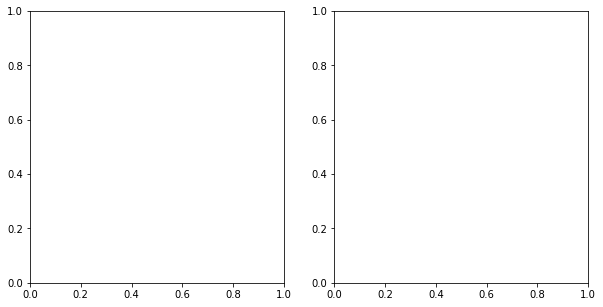

In [7]:
params = {}
params['obs_w'] = width
params['obs_h'] = width
params['integration_step'] = 0.02
system = _sst_module.PSOPTAcrobot()
cpp_propagator = _sst_module.SystemPropagator()
dynamics = lambda x, u, t: cpp_propagator.propagate(system, x, u, t)

vis = AcrobotVisualizer(dynamics, params)
states = path
actions = controls
sgs[0] = wrap_angle(sgs[0], system)
sgs[1] = wrap_angle(sgs[1], system)
print('states:')
print(states)
traj = vis.animate(np.array(states), np.array(actions), np.array(costs), obs_list, np.array(sgs), system)
#HTML(anim.to_html5_video())
#anim.save('acrobot_env%d_path%d.mp4' % (obs_idx, p_idx))

558
in init
state:
[0. 0. 0. 0.]
x1: 0.000000, y1: -20.000000, x2: 0.000000, y2: -40.000000
feasible points
[[-3.14159265 -3.14159265  0.          0.        ]
 [-3.14159265 -3.04159265  0.          0.        ]
 [-3.14159265 -2.94159265  0.          0.        ]
 ...
 [ 2.95840735  2.75840735  0.          0.        ]
 [ 2.95840735  2.85840735  0.          0.        ]
 [ 2.95840735  2.95840735  0.          0.        ]]
infeasible points
[[-3.14159265  1.45840735  0.          0.        ]
 [-3.14159265  1.55840735  0.          0.        ]
 [-3.14159265  1.65840735  0.          0.        ]
 ...
 [ 2.95840735  1.75840735  0.          0.        ]
 [ 2.95840735  1.85840735  0.          0.        ]
 [ 2.95840735  1.95840735  0.          0.        ]]
after init


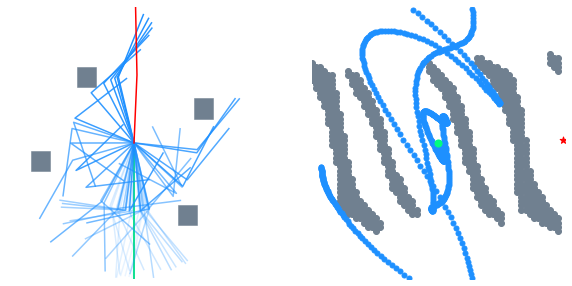

In [11]:
color_dict = {'start_color': 'springgreen', 'intermediate_color': 'dodgerblue', 'goal_color': 'red', 'obs_color':'slategray'}


fig = plt.gcf()
fig = vis.plot(traj, obs_list, np.array(sgs), color_dict, fig, system)

fig.savefig("acrobot_sst_obs_%d_p_%d.pdf" % (obs_idx, p_idx), bbox_inches='tight')
plt.show()

(4, 1400, 2)
(5600, 2)


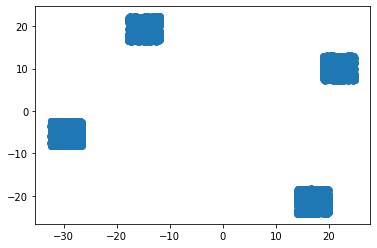

In [9]:
# visualize point cloud
import matplotlib.pyplot as plt
print(obc_list.shape)
obc_all = np.concatenate(obc_list_total[obs_idx], axis=0)
print(obc_all.shape)
plt.scatter(obc_all[:,0], obc_all[:,1])
plt.show()

(5600, 2)


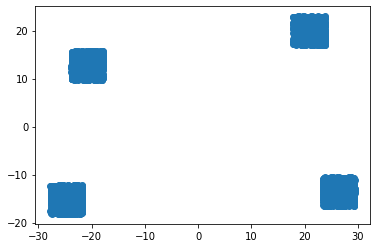

(5600, 2)


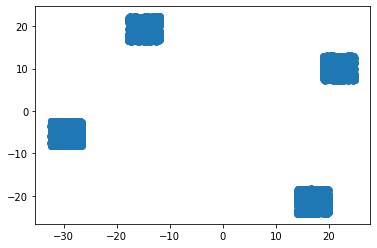

In [10]:
for i in range(2):
    obc_all = np.concatenate(obc_list_total[i], axis=0)
    print(obc_all.shape)
    plt.scatter(obc_all[:,0], obc_all[:,1])
    plt.show()